<div align="center"><h1>Recognizing Handwritten Digits from the MNIST Database Using TensorFlow (For Practice)</h1></div>

In [219]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_datasets
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from PIL import Image

<h3>Loading the data set and creating a validation data set using 10000 of the instances from the training data set</h3>

In [94]:
def load_dataset():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    # Normalizing the images by translating all the grey-scale values into a value between and including 0 and 1.
    x_train = x_train.astype(float) / 255
    x_test = x_test.astype(float) / 255
    
    # Creating a validation data set using 10000 records of the training data.
    x_train, x_val = x_train[:-10000], x_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    return x_train, y_train, x_val, y_val, x_test, y_test


In [95]:
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset()

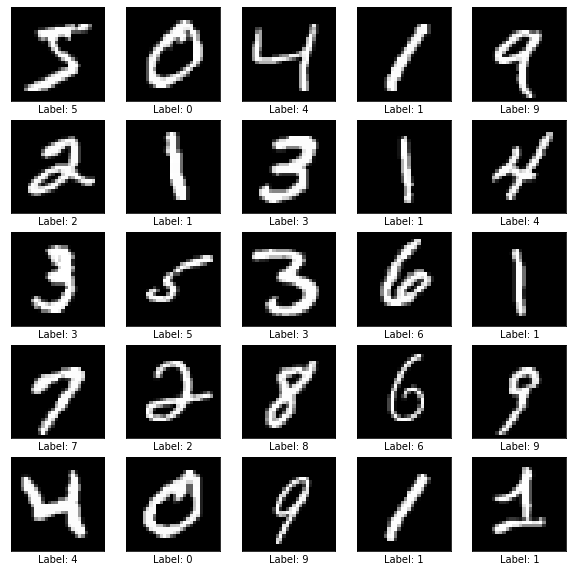

In [258]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap="gray")
    plt.xlabel(f"Label: {y_train[i]}")
plt.show()

<AxesSubplot:>

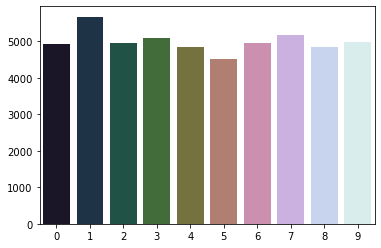

In [246]:
numbers, counts = np.unique(y_train, return_counts=True)
palette = sns.color_palette("cubehelix", 10)
sns.barplot(x=numbers, y=counts, palette=palette)

<font size=3>There's a somewhat uniform distribution of instances per class in the data set, so accounting for class imbalance is not really necesssary</font>

<h3>One-hot encoding the labels.</h3>

In [257]:
y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

print(y_train[0])
print()
print("One-hot encoded list as binary values")
for index, val in enumerate(list(y_train_oh[0].astype(int))):
    print(f"{index}: {val}")

5

One-hot encoded list as binary values
0: 0
1: 0
2: 0
3: 0
4: 0
5: 1
6: 0
7: 0
8: 0
9: 0


<font size=3>The above example demonstrates what one-hot encoding does: it takes all the classes and converts them into a vector of binary values. The bit at the index of the class is set to 1 if it's present for the instance; otherwise, it's set to 0.</font>

<h1>Creating the Neural Network</h1>

<h3>The activation function: Softmax</h3>

<font size=3>The first model I create is a simple neural network with one dense output layer that applies the softmax activation function on label predictions so that they can be represented as probability distributions. The formula for the softmax function:</font><br><br>
    <div align="center"><font size=5>$\sigma(\vec{e})_{i} =\frac{e^{z_{i}}}{\sum \limits_{j=1}^{K}e^{z_{j}}}$</font></div>
<font size=3>
Where $\vec{e}$ is the input vector, $e^{z_{i}}$ is the exponential of the value in the vector, and $\sum \limits_{j=1}^{K}e^{z_{j}}$ is the sum of the exponentials of all the values in the vector.
</font>


In [353]:
x = np.linspace(1, 10, 10, dtype=np.float64)
print(f"Values before applying softmax to the vector: {list(x)}")

# softmax can't take in a 1d array for whatever reason, so I reshape it to be 2d.
x = x.reshape(1, -1)
x = tf.convert_to_tensor(x)
norm = np.around(np.array(keras.activations.softmax(x)).reshape(-1), decimals=2)
print(f"Values after applying softmax: {list(norm)}")

sum_vals = 0
for val in norm:
    sum_vals += val
print(f"Sum of all values after softmax normalization: {sum_vals}")

Values before applying softmax to the vector: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Values after applying softmax: [0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.09, 0.23, 0.63]
Sum of all values after softmax normalization: 0.99


<font size=3>We can see from the above demonstration that softmax squishes all the data into the range [0, 1] such that the sum of all the normalized values is 1. This is useful for multi-class classification where the output for each label prediction must be some probability between 0 and 1.</font>

<h3>The loss function: Cross-entropy</h3>

<font size=3>The models use categorical cross-entropy as a loss function. The formula (yay, more symbols...):</font><br>
<div align="center"><font size=4>$Loss = -\sum \limits_{i=1}^{K}y_{i}\cdot log(\hat{y}_{i})$</font></div>
<font size=3>
Where ${K}$ is the input vector size, $y_{i}$ is the actual label, and $\hat{y}_{i}$ is the probability of the predicted value (the predicted value after undergoing the softmax function). Because the actual labels are one-hot encoded, the only value that's going to affect the loss is the label that is active, because the inactive labels are 0, which means $y_{i}$ is 0. So the loss is determined only by how far off the model's prediction was from the actual label value (which is 1). We can see from the formula that the further off the prediction was from the actual value (i.e. the closer the value was to 0, or the further it was from 1), the larger the loss, and this grows exponentially the further you get from the actual value. Below I plot the negative logarithmic graph to demonstrate this.</font>

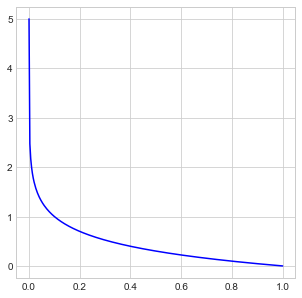

In [373]:
import math
from scipy import interpolate
plt.style.use('seaborn-whitegrid')

def f(x):
    return -math.log(x, 10)

lower_bound = 0.00001
upper_bound = 1
num_steps = 300
x = np.linspace(lower_bound, upper_bound, num_steps)
y = np.array(list(map(f, x)))
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, y, color="blue");

<font size=4>The graph above is the negative logarithmic graph, base 10, from an x-value of 0.00001 to 1.<br>
It's clear that if the prediction is close to 0, it tends to infinity, while if it's a perfect prediction (1), the loss is 0.
</font>

<h3>Simplest model: 1 dense layer</h3>

In [376]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(10, input_shape=(784, ), activation="softmax"))

model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_32 (Flatten)        (None, 784)               0         
                                                                 
 dense_88 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [377]:
history = model.fit(x_train, 
                   y_train_oh,
                   epochs=3,
                   validation_data=(x_val, y_val_oh)
)

Epoch 1/3
1563/1563 [==============================] - 15s 10ms/step - loss: 0.5057 - accuracy: 0.8687 - val_loss: 0.3136 - val_accuracy: 0.9132
Epoch 2/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3167 - accuracy: 0.9112 - val_loss: 0.2784 - val_accuracy: 0.9239
Epoch 3/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2929 - accuracy: 0.9179 - val_loss: 0.2693 - val_accuracy: 0.9260


<font size=3>The model achieves an accuracy of 92.6% after 3 epochs which is not too bad considering this is the simplest possible model you can make</font>

<h3>More dense layers</h3>

In [380]:
model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax")    
])

model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_34 (Flatten)        (None, 784)               0         
                                                                 
 dense_92 (Dense)            (None, 256)               200960    
                                                                 
 dense_93 (Dense)            (None, 256)               65792     
                                                                 
 dense_94 (Dense)            (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [381]:
history = model.fit(x_train, 
                    y_train_oh, 
                    epochs=3,
                   validation_data=(x_val, y_val_oh)
)

Epoch 1/3
1563/1563 [==============================] - 18s 12ms/step - loss: 0.2173 - accuracy: 0.9337 - val_loss: 0.1001 - val_accuracy: 0.9696
Epoch 2/3
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0890 - accuracy: 0.9725 - val_loss: 0.0971 - val_accuracy: 0.9699
Epoch 3/3
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0612 - accuracy: 0.9808 - val_loss: 0.0862 - val_accuracy: 0.9749


In [389]:
print(f"Accuracy after 3 epochs of training: {np.max(history.history['accuracy'])}")

Accuracy after 3 epochs of training: 0.9808200597763062


<h3>Performance on the testing data set</h3>

In [392]:
results = model.evaluate(x_test, y_test_oh, batch_size=128)
print(f"Accuracy: {results[1]}")

79/79 [==============================] - 1s 8ms/step - loss: 0.0780 - accuracy: 0.9759
Accuracy: 0.9759000539779663


In [394]:
y_pred = model.predict(x_test)
y_pred = [np.argmax(i) for i in y_pred]

Text(73.5, 0.5, 'Truth')

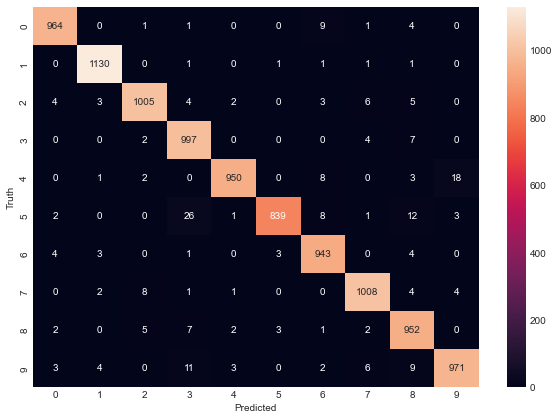

In [396]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth");

<font size=3>The main diagonal in the confusion matrix contains the number of correctly predicted values for each label.</font>

<font size=3>I'll now display a sample of images from the test set and the predicted labels for the images</font>

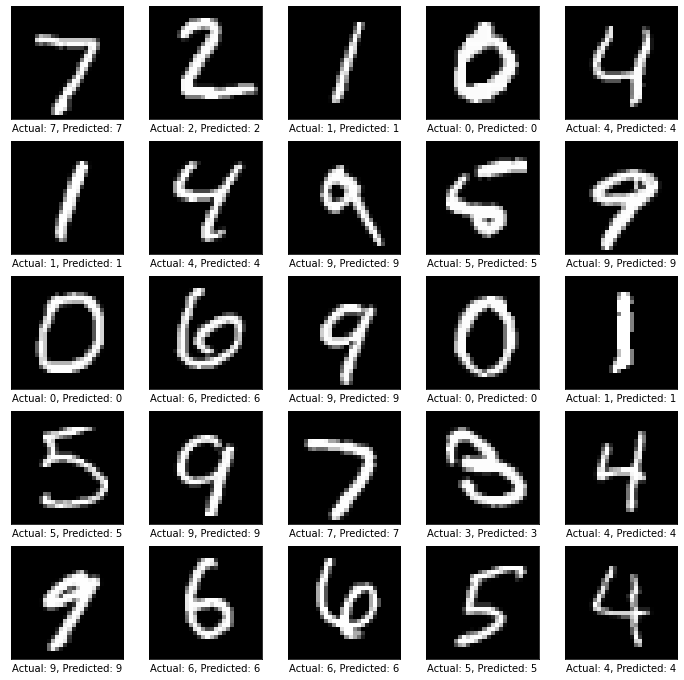

In [214]:
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i], cmap="gray")
    y_pred = np.argmax(y_predictions[i])
    plt.xlabel(f"Actual: {y_test[i]}, Predicted: {y_pred}")

<h1>Experimenting With a Convolutional Neural Network</h1>

<font size=3>Before feeding the training data into the CNN, I need to reshape the data so that it each instance is 3-dimensional, where the first 2 dimensions represent the dimensions of the image, while the 3rd dimensions represents the value of the channel of the pixel.</font>

In [413]:
new_x_train = x_train.reshape(len(x_train), 28, 28, -1)
new_x_val = x_val.reshape(len(x_val), 28, 28, -1)
print(new_x_train.shape)
print(new_x_val.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)


In [412]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu")
])

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 flatten_37 (Flatten)        (None, 3872)              0         
                                                                 
 dense_97 (Dense)            (None, 64)                247872    
                                                                 
 dense_98 (Dense)            (None, 10)                650       
                                                     

In [420]:
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

history = model.fit(new_x_train,
                   y_train_oh, 
                   epochs=5,
                   validation_data=(new_x_val, y_val_oh)
)

Epoch 1/5
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0246 - accuracy: 0.9914 - val_loss: 0.0415 - val_accuracy: 0.9882
Epoch 2/5
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0151 - accuracy: 0.9953 - val_loss: 0.0470 - val_accuracy: 0.9888
Epoch 3/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0118 - accuracy: 0.9959 - val_loss: 0.0541 - val_accuracy: 0.9865
Epoch 4/5
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.0696 - val_accuracy: 0.9877
Epoch 5/5
1563/1563 [==============================] - 26s 17ms/step - loss: 0.0082 - accuracy: 0.9970 - val_loss: 0.0498 - val_accuracy: 0.9902


In [430]:
accuracy = round(np.max(history.history["accuracy"])*100, 3)
print(f"Accuracy after 5 epochs of training: {accuracy}")

Accuracy after 5 epochs of training: 99.704


<font size=3>The CNN does an absolutely fantastic job. I don't think you can quite do much better than that.</font>